In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.insert(0, '/home/brysongray/fibermetric/')
from fibermetric import histology, sta_validate
import numpy as np
import matplotlib.pyplot as plt
%matplotlib widget
from scipy.ndimage import gaussian_filter,sobel,correlate1d,gaussian_filter1d
import cv2
import scipy
import itertools

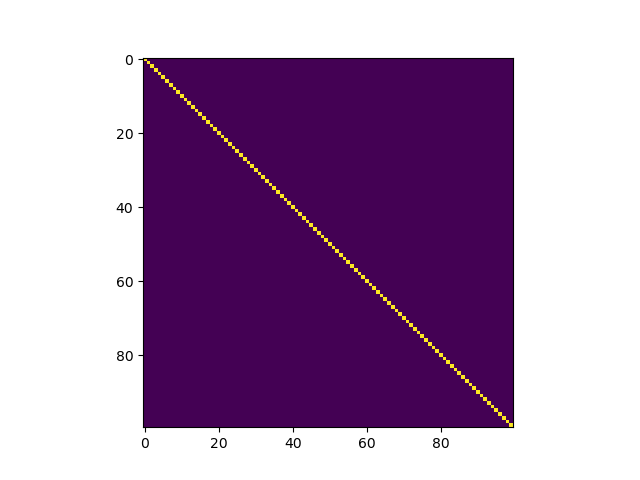

In [3]:
image = np.zeros((5,100,100))
image = sta_validate.draw_line_3D(image, (2,0,0), (2,99,99))
plt.figure()
plt.imshow(image[2])

## test 3D line phantom

test
(20, 120, 120)


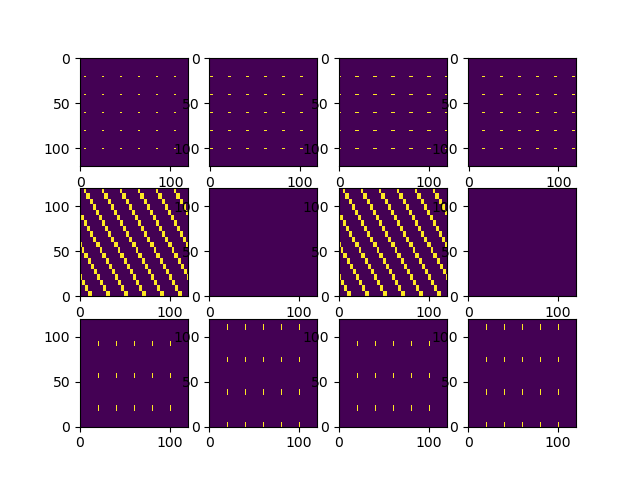

In [86]:
img = sta_validate.parallel_lines_3D((20,120,120), theta=np.pi/6, phi=0, period=20, width=1)
fig, axs = plt.subplots(3,4)
print(img.shape)
for i in range(4):
    axs[0][i].imshow(img[i*5,:,:], interpolation='none') # xy-plane
for i in range(4):
    axs[1][i].imshow(img[:,i*30,:], extent=(0, 120, 0, 120), interpolation='none') # xz-plane
for i in range(4):
    axs[2][i].imshow(img[:,:,i*30], extent=(0, 120, 0, 120), interpolation='none') # yz-plane

In [21]:
S = histology.structure_tensor(img, dI=(6,1,1))


In [22]:
theta,phi = histology.angles(S)

Text(0.5, 1.0, 'phi')

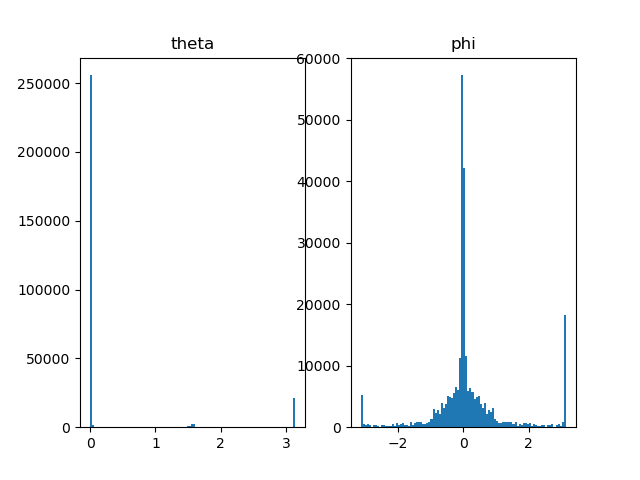

In [23]:
fig, axs = plt.subplots(1,2)
# plot a histogram of theta
axs[0].hist(theta.flatten(), bins=100)
axs[0].set_title('theta')
# plot a histogram of phi
axs[1].hist(phi.flatten(), bins=100)
axs[1].set_title('phi')

In [17]:
np.pi/2

1.5707963267948966

## Test circle drawing methods

In [4]:
def circle(img, dI, radius, sigma):
    """ draw a circle centered at the image center with arbitrary pixel dimensions.

    Parameters
    ----------
    img : array
    dI : list or tuple
        pixel dimensions
    center : list or tuple
    radius : float
    sigma : float
        standard deviation used in the gaussian filter for antialiasing

    Returns
    -------
    img : array

    """

    # handle cases where part of the circle is out of bounds
    img_size = np.array([n/2*d for n,d in zip(img.shape,dI)])
    max_radius = np.sqrt(np.sum(img_size**2))
    if radius >= max_radius:
        return img
    else:
        xI = [(np.arange(x) - (x-1)//2)*d for x,d in zip(img.shape,dI)]
        XI = np.stack(np.meshgrid(*xI, indexing='ij'))
        img[np.where(np.isclose(np.sqrt(XI[0]**2 + XI[1]**2), radius, atol=np.sqrt(dI[0]**2+dI[1]**2)/2))] = 1.0
        img = gaussian_filter(img,sigma=(sigma/dI[0], sigma/dI[1]))
        extent = (xI[1][0]-dI[1]/2, xI[1][-1]+dI[1]/2, xI[0][-1]+dI[0]/2, xI[0][0]-dI[0]/2)
    return img, extent


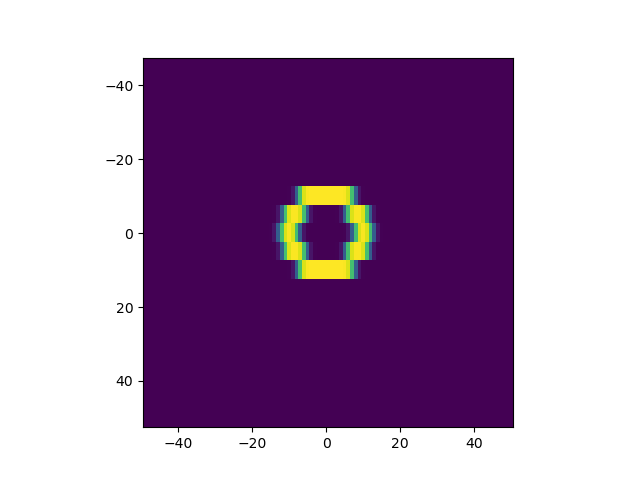

In [5]:
img = np.zeros((20,100))

circ, extent = circle(img, (5.0,1.0), radius=10.0, sigma=1.0)
plt.figure()
plt.imshow(circ, extent=extent)

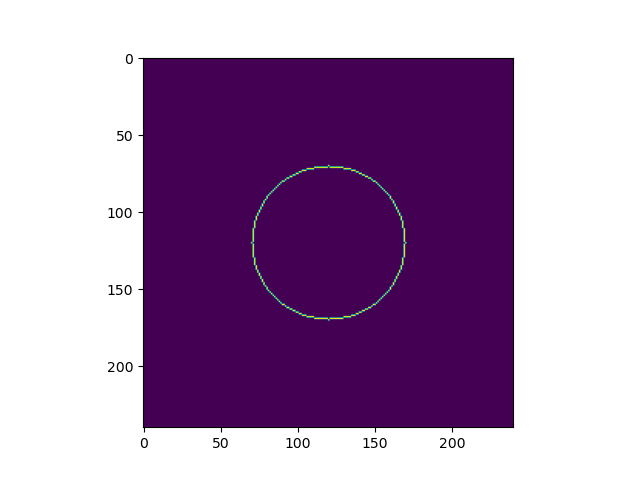

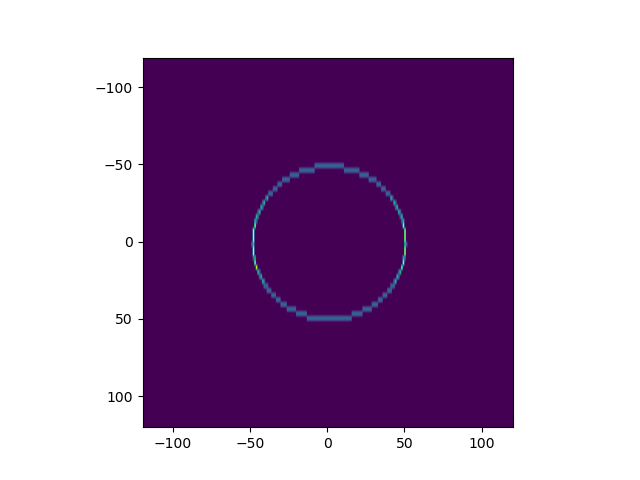

In [6]:
nI = (240,240)
downsample_factor = (3,1)
I, labels, extent = sta_validate.circle(nI, period=1000, width=1, noise=0.0, min_radius=50)
plt.figure()
plt.imshow(I)
I_down = sta_validate.downsample_image(I, downsample_factor)
xI = [np.arange(n) - (n-1)//2 for n in nI]
dI = [downsample_factor[1]/downsample_factor[0], 1.0]
extent = (xI[1][0]-dI[1]/2, xI[1][-1]+dI[1]/2, xI[0][-1]+dI[0]/2, xI[0][0]-dI[0]/2)
plt.figure()
plt.imshow(I_down, extent=extent)

In [20]:
width=2
derivative_sigmas = np.arange(start=1/width, stop=width*2,step=width/6)
print(derivative_sigmas)
print(len(derivative_sigmas))

[0.5        0.83333333 1.16666667 1.5        1.83333333 2.16666667
 2.5        2.83333333 3.16666667 3.5        3.83333333]
11


In [16]:
width = 5
derivative_sigmas = np.arange(start=1/width, stop=width*5,step=width/2)
print(derivative_sigmas)

[ 0.2  2.7  5.2  7.7 10.2 12.7 15.2 17.7 20.2 22.7]


[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


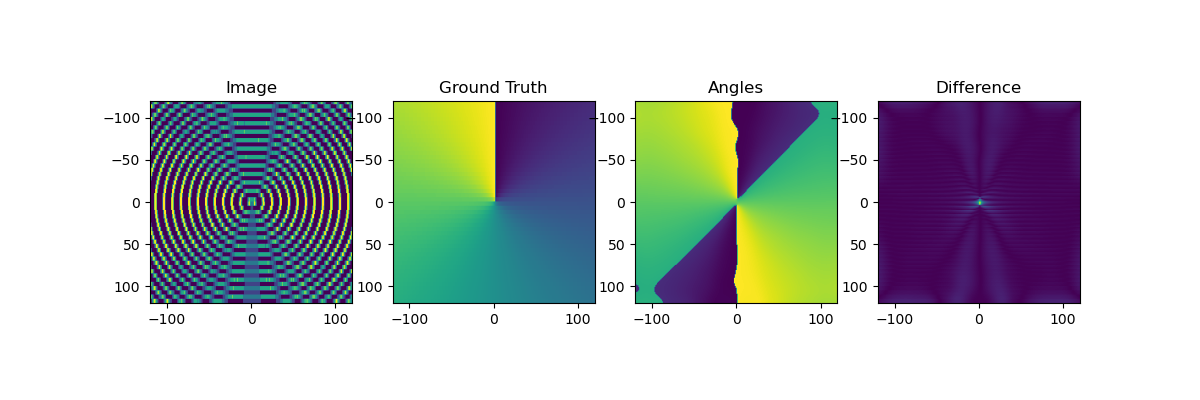

pixelwise error: 2.2749665522760214


In [9]:
width = 2
derivative_sigmas = np.arange(start=1/width, stop=width*5,step=width/2)
print(derivative_sigmas)
tensor_sigmas = np.arange(start=1/width, stop=width*5,step=width/2)
print(tensor_sigmas)
anisotropy = [(240,240), (210,240),(180,240),(150,240),(120,240),(80,240),(60,240),(48,240)]
d = 2
t = 9
a = 7
err_type = 'pixelwise'
error = sta_validate.phantom_test(derivative_sigmas[d], tensor_sigmas[t], anisotropy[a], period=10, noise=0.0, width=width, phantom='circles', err_type=err_type, display=True) # , grid_thetas=(-np.pi/6,np.pi/3)
print(f'{err_type} error: {error}')

In [10]:
width = 2
derivative_sigmas = np.arange(start=1/width, stop=width*5,step=width/2)
print(derivative_sigmas)
tensor_sigmas = np.arange(start=1/width, stop=width*5,step=width/2)
print(tensor_sigmas)
anisotropy = [(240,240), (210,240),(180,240),(150,240),(120,240),(80,240),(60,240),(48,240)]
errors = sta_validate.run_tests(derivative_sigmas=derivative_sigmas, tensor_sigmas=tensor_sigmas, nIs=anisotropy, periods=10, widths=width, noises=0.0, phantom='circles', err_type='pixelwise')

[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]
[0.5 1.5 2.5 3.5 4.5 5.5 6.5 7.5 8.5 9.5]


  0%|          | 0/800 [00:00<?, ?it/s]

In [11]:
print(errors[:10])
np.save('errors.npy', errors)

   derivative_sigma  tensor_sigma          nI  period  width  noise  phantom  \
0               0.5           0.5  (240, 240)    10.0    2.0    0.0  circles   
1               0.5           0.5  (210, 240)    10.0    2.0    0.0  circles   
2               0.5           0.5  (180, 240)    10.0    2.0    0.0  circles   
3               0.5           0.5  (150, 240)    10.0    2.0    0.0  circles   
4               0.5           0.5  (120, 240)    10.0    2.0    0.0  circles   
5               0.5           0.5   (80, 240)    10.0    2.0    0.0  circles   
6               0.5           0.5   (60, 240)    10.0    2.0    0.0  circles   
7               0.5           0.5   (48, 240)    10.0    2.0    0.0  circles   
8               0.5           1.5  (240, 240)    10.0    2.0    0.0  circles   
9               0.5           1.5  (210, 240)    10.0    2.0    0.0  circles   

  error type grid thetas tile size  dimensions      error  
0  pixelwise      [None]      None         2.0   9.882080  

/tmp/ipykernel_1152221/1946347407.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


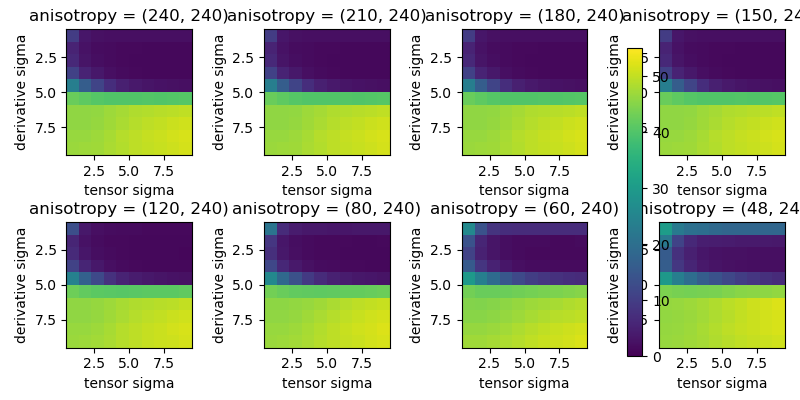

In [18]:
error = []
for i in range(len(anisotropy)):
    # get the error value from errors where anisotropy is anisotropy[i]
    error.append(np.array(errors[errors['nI'] == anisotropy[i]]['error']))
    # reshape the error1 into a 2D array where rows are derivative_sigmas and columns are tensor_sigmas
    error[i] = error[i].reshape((len(derivative_sigmas),len(tensor_sigmas)))
# initialize a figure with 2 rows and 5 columns
rows = 2
cols = 4
fig, axs = plt.subplots(rows,cols, figsize=(8,4))
# plot each array in error as a heat map in
for i in range(len(anisotropy)):
    axs[i//cols,i%cols].imshow(error[i], extent=(tensor_sigmas[0],tensor_sigmas[-1],derivative_sigmas[-1],derivative_sigmas[0]), vmin=0, vmax=55)
    axs[i//cols,i%cols].set_title(f'anisotropy = {anisotropy[i]}')
    axs[i//cols,i%cols].set_xlabel('tensor sigma')
    axs[i//cols,i%cols].set_ylabel('derivative sigma')
# add colorbar to the right
cbar = fig.colorbar(axs[0,0].images[0], ax=axs, location='right')
    # axs[i//5,i%5].set_aspect('auto')
plt.tight_layout()


In [19]:
error_ = np.stack(error)
err_argmin = np.argmin(error_.reshape(error_.shape[0],-1), axis=1)
err_argmin = np.apply_along_axis(np.unravel_index, 0, err_argmin, error_.shape[1:])
print(err_argmin)
# tsigma_hat = np.argmin(error[range(len(anisotropy)),dsigma_hat])
# print(dsigma_hat)

[[2 2 2 2 2 2 2 3]
 [9 9 9 9 9 9 8 9]]


In [81]:
tsigma_hat = np.argmin(error[:,dsigma_hat[0],range(9)], axis=1)
print(tsigma_hat)
# best_error_ids = 

[8 8 8 8 8 8 2 3 0]


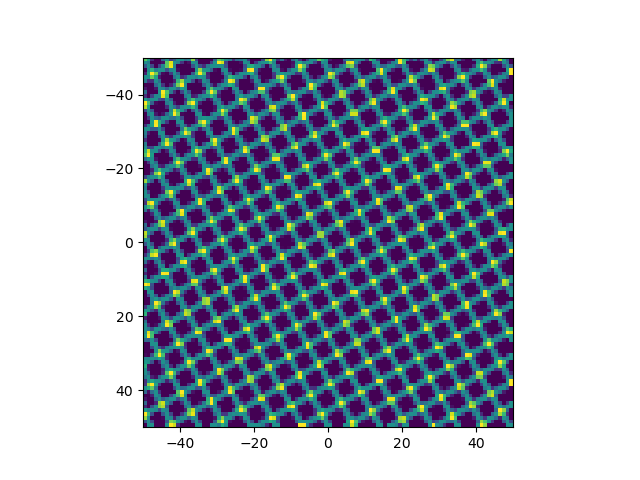

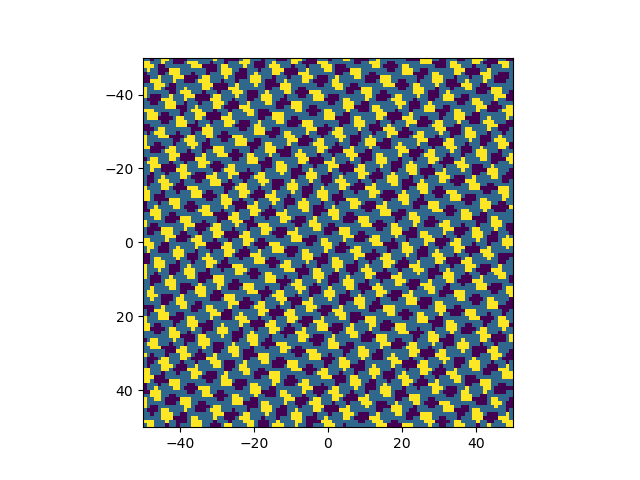

In [34]:
I, labels, extent = sta_validate.parallel_lines_2d(thetas=[np.pi/3,-np.pi/6], nI=(100,100), period=6, width=1, noise=0.0)
plt.figure()
plt.imshow(I, extent=extent)
plt.figure()
plt.imshow(labels, extent=extent)


In [23]:
S = histology.structure_tensor(I, derivative_sigma=0.5, tensor_sigma=1.0, dI=(1.0,1.0))
angles = histology.angles(S)[0]
# odf, mu, kappa = histology.odf2d_vonmises(angles, nbins=100, tile_size=250, n_components=3, verbose=True)

In [30]:
# odf, sample_points = histology.odf2d(angles, nbins=100, tile_size=100, damping=0.1)
odf, mu, kappa, pi = histology.odf2d_vonmises(angles, nbins=100, tile_size=100, verbose=True)
print(odf.shape)

inital means:  [-0.63984303  0.93975161]
Optimization terminated successfully.
         Current function value: 8076.672131
         Iterations: 389
         Function evaluations: 620
(1, 1, 100)


In [49]:
a = (2,-3)
print(a)
a = np.sort(np.array(a))
print(a)
# a = list(a).sort()
# # a = np.array([a].sort())
# print(a)

(2, -3)
[-3  2]


In [53]:
error = sta_validate.phantom_test(0.5, 1.0, (100,100), period=8, phantom='grid', err_type='piecewise', grid_thetas=(np.pi/3,-np.pi/6))#, tile_size=100)
print(error)

4.093591950532443


In [ ]:
# compare odf to the ground truth distribution using jenson-shannon divergence.
# the ground truth is a distribution of delta functions at the angles of the lines.
grid_thetas=[np.pi/3,-np.pi/6]
thetas_symmetric = np.concatenate((grid_thetas, np.array(grid_thetas) + np.pi))
thetas_symmetric = np.where(thetas_symmetric > np.pi, thetas_symmetric - 2*np.pi, thetas_symmetric)
print(f'thetas = {thetas_symmetric}')
ground_truth = np.zeros(odf.shape[-1])
ground_truth[np.digitize(thetas_symmetric, sample_points)] = 1.0 / len(thetas_symmetric)
# ground_truth = gaussian_filter(ground_truth, sigma=1)
js = np.apply_along_axis(lambda a: scipy.spatial.distance.jensenshannon(a, ground_truth), axis=-1, arr=odf)
error = np.mean(js)

plt.figure()
plt.plot(sample_points, ground_truth)

plt.figure()
plt.plot(sample_points, odf[0,0])

print(f'jensen-shannon divergence: {js[0,0]}')
# ground_truth = np.zeros(odf.shape[-1])
# thetas_=[np.pi/3,-np.pi/6, np.pi/3-np.pi, -np.pi/6+np.pi]
# # ground_truth[np.argmin(np.abs(sample_points[:,None]-np.array(thetas_)[None]))] = 1.0 / len(thetas_)
# ground_truth[np.digitize(thetas_, sample_points)] = 1.0 / len(thetas_)
# ground_truth = gaussian_filter1d(ground_truth, sigma=1.0)

In [ ]:
# display angles
plt.figure()
plt.imshow(angles)#, extent=extent)
plt.figure()
plt.hist(angles[~np.isnan(angles)].flatten(), bins=100)
plt.show()

In [ ]:
# odf, mu, kappa, pi = histology.odf2d_vonmises(angles, nbins=100, tile_size=250, n_components=2, verbose=True)
# print('mu = ', mu)
# print('kappa = ', kappa)
# print('pi = ', pi)

In [ ]:
odf, sample_points = histology.odf2d(angles, nbins=100, tile_size=25)
odf_peaks = np.apply_along_axis(lambda a: scipy.signal.find_peaks(a, prominence=0.005)[0], axis=-1, arr=odf)
# take only angles in the range -pi/2, pi/2
peaks = np.apply_along_axis(lambda a: [p for p in sample_points[a] if p >= -np.pi/2 and p <= np.pi/2 ], axis=-1, arr=odf_peaks)
thetas=[np.pi/3,-np.pi/6]
# assert peaks.shape[-1] == len(thetas), 'number of peaks detected does not equal the number of angles in the image'
# err = []
# for thetas_perm in list(itertools.permutations(thetas)):
#     err.append(np.sum(np.abs(peaks - thetas_perm), axis=-1) / len(thetas))
# err = err[np.argmin([np.sum(x) for x in err])]

In [ ]:
diff = np.sum(np.abs(peaks - thetas), axis=-1) / len(thetas)
diff.shape

In [ ]:
avg_diff = np.sum(np.abs(peaks - thetas)) / np.prod(peaks.shape)
print(avg_diff)

In [ ]:
print(angles.shape)
tile_size = 250
nbins = 100
damping = 0.1
i, j = [x//tile_size for x in angles.shape]
theta = np.array(angles[:i*tile_size,:j*tile_size]) # crop so theta divides evenly into tile_size (must create a new array to change stride lengths too.)
# reshape into tiles by manipulating strides. (np.reshape preserves contiguity of elements, which we don't want in this case)
nbits = theta.strides[-1]
theta = np.lib.stride_tricks.as_strided(theta, shape=(i,j,tile_size,tile_size), strides=(tile_size*theta.shape[1]*nbits,tile_size*nbits,theta.shape[1]*nbits,nbits))
theta = theta.reshape(i,j,tile_size**2)
theta_flip = theta - np.pi
theta_flip = np.where(theta_flip < -1*np.pi, theta_flip + 2*np.pi, theta_flip)
theta = np.concatenate((theta,theta_flip), axis=-1)
print('fitting to fourier series...')
odf = np.apply_along_axis(lambda a: np.histogram(a[~np.isnan(a)], bins=nbins, range=(-np.pi,np.pi))[0], axis=-1, arr=theta)
step = 2*np.pi/nbins
t = np.linspace(-np.pi+step/2, np.pi-step/2, nbins)
odf_F = np.fft.rfft(odf)
n = np.arange(odf_F.shape[-1])
odf_F = odf_F * np.exp(-1*damping*n) # apply damping
odf = np.fft.irfft(odf_F, nbins)
odf = odf / np.sum(odf, axis=-1)[...,None] # normalize to make this a pdf

In [ ]:
odf[0,0]

In [ ]:
fig,ax = plt.subplots(subplot_kw={'projection':'polar'})
ax.plot(t, odf[0,0])
plt.show()
odf_peaks = scipy.signal.find_peaks(odf[0,0], prominence=0.005)[0]
# take only angles in the range -pi/2, pi/2
peaks = [p for p in t[odf_peaks] if p >= -np.pi/2 and p <= np.pi/2 ]
print(odf_peaks)
print(peaks)


In [ ]:
odf_ = np.concatenate((odf[0,0], odf[0,0]), axis=0)
fig = plt.figure()
ax = fig.add_subplot(111, projection='polar')
ax.plot(np.linspace(-np.pi, np.pi, odf_.shape[0]), odf_)
plt.show()



In [ ]:
odf_.shape

In [ ]:
nI=(200,200)
dI=(nI[1]/nI[0],1.0)
# xI = [(np.arange(n) - (n-1)/2)*d for n,d in zip(nI,dI)]
# XI = np.stack(np.meshgrid(*xI,indexing='ij'),-1)
start = -np.pi/2+np.pi/20
stop = np.pi/2+np.pi/20
step = (stop-start)/5
thetas = np.arange(start=start, stop=stop, step=step)
print('thetas',thetas*(180/np.pi))
I, mask, labels, extentI = synthetic2d(thetas=thetas, nI=nI, dI=dI, width=2, blur=2.0, noise=0.05, mask_thresh=0.99)
# circle_img, circle_mask, circle_labels, extent_circle = circle(20, nI=nI, dI=dI)
print(f'shape: {I.shape}')
fig,axs = plt.subplots(3)
axs[0,].imshow(I, extent=extentI)
axs[0].set_title('I')
axs[1].imshow(labels)#,extent=extentI)
axs[1].set_title('labels')
axs[2].imshow(mask)
axs[2].set_title('mask')
# axs[0,1].imshow(circle_img,extent=extent_circle)
# axs[0,1].set_title('circle')
# axs[1,1].imshow(circle_labels, extent=extent_circle)
# axs[1,1].set_title('circle labels')

In [ ]:
nI=(50,200)
dI=(nI[1]/nI[0],1.0)
step = 10
radii = np.arange(10,100+step,step=step)
circle, circ_mask, circ_labels, circ_extent = synthetic_circle(radius=radii, nI=nI, dI=dI, width=2, blur=1.0) #, mask_thresh=0.2)
fig,axs = plt.subplots(2)
axs[0].imshow(circle, extent=circ_extent)
axs[0].set_title('Circles')
axs[1].imshow(circ_labels,extent=circ_extent)
axs[1].set_title('Circle Labels')
print(circle.shape)


## Anisotropy Corrected Circles

In [ ]:
cirImageCorrected, cirMaskCorrected, cirLabelsCorrected, cirExtentCorrected = anisotropy_correction(circle,circ_mask,circ_labels,dI,direction='up')
fig,axs = plt.subplots(2)
axs[0].imshow(cirImageCorrected, extent=cirExtentCorrected)
axs[0].set_title('Circles (Anisotropy Corrected)')
axs[1].imshow(cirLabelsCorrected,extent=cirExtentCorrected)
axs[1].set_title('Circle Labels (Anisotropy Corrected)')
print(cirImageCorrected.shape)

In [ ]:
use_sobel = False
derivative_sigma = 6.0
derivative_sigma = [derivative_sigma/dI[0],derivative_sigma/dI[1]]
I = circle

In [ ]:
if use_sobel:
    Ix = sobel(I,1)/dI[1]
else:
    # Ix = correlate1d(I,np.array([-1,0,1])/2.0/dI[1],1)
    # Ix = gaussian_filter(Ix,sigma=derivative_sigma)
    Ix = gaussian_filter(I, sigma=derivative_sigma, order=[0,1]) / dI[1]

if use_sobel:
    Iy = sobel(I,0)/dI[0]
else:
    # Iy = correlate1d(I,np.array([-1,0,1])/2.0/dI[0],0)
    # Iy = gaussian_filter(Iy,sigma=derivative_sigma)
    Iy = gaussian_filter(I, sigma=derivative_sigma, order=[1,0]) / dI[0]

norm = np.sqrt(Ix**2 + Iy**2)+np.finfo(float).eps
Ix = Ix/norm
Iy = Iy/norm

fig,ax = plt.subplots()
h = ax.imshow(Ix,extent=extentI)
plt.colorbar(mappable=h)
ax.set_title('Ix')

fig,ax = plt.subplots()
h = ax.imshow(Iy,extent=extentI)
plt.colorbar(mappable=h)
ax.set_title('Iy')


In [ ]:

tensor_sigma = 4.0
tensor_sigma = [tensor_sigma/dI[0],tensor_sigma/dI[1]]
Ixx = gaussian_filter(Ix*Ix,sigma=tensor_sigma)
fig,ax = plt.subplots()
h = ax.imshow(Ixx,extent=extentI)
plt.colorbar(mappable=h)
ax.set_title('Ixx')

Ixy = gaussian_filter(Ix*Iy,sigma=tensor_sigma)
fig,ax = plt.subplots()
h = ax.imshow(Ixy,extent=extentI)
plt.colorbar(mappable=h)
ax.set_title('Ixy')

Iyy = gaussian_filter(Iy*Iy,sigma=tensor_sigma)
fig,ax = plt.subplots()
h = ax.imshow(Iyy,extent=extentI)
plt.colorbar(mappable=h)
ax.set_title('Iyy')



In [ ]:
# note S is in XY order, so my glyphs should be too
S = np.stack([1-Ixx,-Ixy,-Ixy,1-Iyy],-1)
# S = np.stack([Ixx,Ixy,Ixy,Iyy],-1)
S = S.reshape(S.shape[0],S.shape[1],2,2)
w,v = np.linalg.eigh(S)
# w = 1.0/w
max_each_pixel = False
if max_each_pixel:
    w = w / np.max(w,-1,keepdims=True)
else:
    w = w / np.max(w)
fig,ax = plt.subplots()
ax.imshow(w[...,0],extent=extentI)
fig,ax = plt.subplots()
ax.imshow(w[...,1],extent=extentI)

In [ ]:
wd = np.stack((np.sqrt(w[...,0]),np.zeros_like(w[...,0]),np.zeros_like(w[...,0]),np.sqrt(w[...,1])),-1).reshape(w.shape[0],w.shape[1],2,2)

In [ ]:
sqrt = v@wd@v.transpose(0,1,3,2)

In [ ]:
# get a circle
scale = 1.0
# scale = (np.max(w,-1)-np.min(w,-1))[...,None,None]*1.0
# scale = (np.ones_like(w) / dI[::-1])[...,None]*2.5
ntheta = 20
thetas = np.arange(ntheta+1)/ntheta*2.0*np.pi
q = np.stack((np.cos(thetas),np.sin(thetas)),0)

glyphs = sqrt@q
glyphs = glyphs*scale

xI = [(np.arange(n) - (n-1)//2)*d for n,d in zip(nI,dI)]
XI = np.stack(np.meshgrid(*xI,indexing='ij'),-1)

glyphs = glyphs + XI[...,::-1,None] # flip row col to xy

down = np.array([4,4])
fig,ax = plt.subplots()
ax.imshow(I,extent=extentI)
for i in range(0,glyphs.shape[0],down[0]):
    for j in range(0,glyphs.shape[1],down[1]):
        ax.plot(glyphs[i,j,0],glyphs[i,j,1],color='k')

In [ ]:
# angles = (histology.angles(S)[0] * np.pi - np.pi/2)*(180/np.pi)
angles = histology.angles(S)[0]*(180/np.pi)
diff = np.abs(angles - circ_labels)
diff = np.where(diff>90.0,np.abs(180-diff),diff)
fig,axs = plt.subplots(2,)
axs[0].imshow(angles*circ_mask, extent=extentI)
axs[0].set_title('angles')
axs[1].imshow(diff*circ_mask,extent=extentI)
axs[1].set_title('Error (degrees)')
mean_error = np.sum(diff*circ_mask)/np.sum(circ_mask)
print(f'mean_error: {mean_error}')

# Test with Radial Line Phantom


### set up parameters

In [ ]:
derivative_sigmas = np.arange(start=2.0, stop=22.0,step=2.0)
tensor_sigmas = np.arange(start=2.0, stop=22.0,step=2.0)
anisotropy = [(200,200),(100,200),(67,200),(50,200),(40,200),(34,200),(28,200),(25,200),(22,200),(20,200)]
start = -np.pi/2+np.pi/20
stop = np.pi/2 + np.pi/20
stepsize = (stop-start)/10
line_angles = np.arange(start=start, stop=stop, step=stepsize)

print(derivative_sigmas.shape,
      tensor_sigmas.shape,
      line_angles.shape)

In [ ]:
blur = 2.0

errors = np.zeros((len(line_angles), len(anisotropy), len(derivative_sigmas), len(tensor_sigmas)))

for i,line_angle in enumerate(line_angles):
    for j, nI in enumerate(anisotropy):
        dI = (nI[1]/nI[0], 1.0)
        I, mask,labels,extentI = synthetic2d(thetas=[line_angle], nI=nI, dI=dI, width=1, blur=blur, noise=0.05, mask_thresh=0.99)
        for k,dsig in enumerate(derivative_sigmas):
            for l,tsig in enumerate(tensor_sigmas):
                derivative_sigma = [dsig/dI[0],dsig/dI[1]]
                Ix = gaussian_filter(I, sigma=derivative_sigma, order=[0,1]) / dI[1]
                Iy = gaussian_filter(I, sigma=derivative_sigma, order=[1,0]) / dI[0]
                norm = np.sqrt(Ix**2 + Iy**2)+1e-5
                Ix = Ix/norm
                Iy = Iy/norm
                tensor_sigma = [tsig/dI[0],tsig/dI[1]]
                Ixx = gaussian_filter(Ix*Ix,sigma=tensor_sigma)
                Ixy = gaussian_filter(Ix*Iy,sigma=tensor_sigma)
                Iyy = gaussian_filter(Iy*Iy,sigma=tensor_sigma)
                S = np.stack([1-Ixx,-Ixy,-Ixy,1-Iyy],-1)
                S = S.reshape(S.shape[0],S.shape[1],2,2)
                
                angles = histology.angles(S)[0]*(180/np.pi)
                diff = np.abs(angles - labels)
                diff = np.where(diff>90.0,np.abs(180-diff),diff)
                mean_error = np.sum(diff*mask)/np.sum(mask)

                errors[i,j,k,l] = mean_error


In [ ]:
errors.shape

In [ ]:
avg_angle_err = np.sum(errors,axis=0)/errors.shape[0]
fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(16,8))
plt.setp(axs, xticks=range(10),xticklabels=tensor_sigmas, yticks=range(10),yticklabels=derivative_sigmas)
for i in range(10):
    m = i//5
    n = i%5
    ax = axs[m,n]
    # im = ax.imshow(np.sum(errors[i], axis=0)/errors[i].shape[0])
    im = ax.imshow(avg_angle_err[i], vmin=0.0, vmax=45., cmap='jet')
    ax.set_title(f'anisotropy {anisotropy[i]}')
    ax.set_ylabel('derivative sigma')
    # ax.xticks(labels=tensor_sigmas)
    ax.set_xlabel('tensor sigma')
    # ax.yticks(labels=derivative_sigmas)

# fig, ax = plt.subplots(figsize=(10,10))
# im = ax.imshow(np.sum(errors,axis=0)/errors.shape[0])
# ax.set_title(f'angular error (degrees)')
# ax.set_xlabel('derivative sigma')
# ax.set_ylabel('tensor sigma')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

for a in range(len(anisotropy)):
    # arr = np.sum(errors[a],axis=0)/errors[a].shape[0] # sum over line angles
    arr = avg_angle_err[a]
    min = np.nanargmin(arr)
    if arr.ndim == 4:
        min_i = min//(arr.shape[0]*arr.shape[1]*arr.shape[2])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]))//(arr.shape[1]*arr.shape[2])
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]))//arr.shape[2]
        min_l = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]) - min_k*arr.shape[2])
        print(f'min idx: ({min_i},{min_j},{min_k},{min_l})')
    elif arr.ndim == 3:
        min_i = min//(arr.shape[0]*arr.shape[1])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]))//arr.shape[1]
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]) - min_j*(arr.shape[1]))
        print(f'min idx: ({min_i},{min_j},{min_k})')
    elif arr.ndim == 2:
        min_i = min//(arr.shape[0])
        min_j = (min - min_i*(arr.shape[0]))
        print(f'anisotropy={anisotropy[a]}; min idx: ({min_i},{min_j})')

In [ ]:
AI_ratio = [np.round(a[1]/a[0], decimals=2) for a in anisotropy]
print(AI_ratio)

In [ ]:
# avg_angle_err = np.sum(errors,axis=0)/errors.shape[0]
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
plt.setp(axs, xticks=range(10),xticklabels=AI_ratio, yticks=range(10), yticklabels=line_angles*(180/np.pi))

im = axs.imshow(errors[...,3,5], vmin=0.0, vmax=11.)
axs.set_title(f'angular error (degrees)')
axs.set_xlabel('anisotropy')
axs.set_ylabel('angle')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


### plot error with anisotropy correction

In [ ]:
blur = 2.0

errors_corrected = np.zeros((len(line_angles), len(anisotropy), len(derivative_sigmas), len(tensor_sigmas)))

for i,line_angle in enumerate(line_angles):
    for j, nI in enumerate(anisotropy):
        dI = (nI[1]/nI[0], 1.0)
        I, mask,labels,extentI = synthetic2d(thetas=[line_angle], nI=nI, dI=dI, width=1, blur=blur, noise=0.05, mask_thresh=0.99)
        I_corrected, mask_corrected, labels_corrected, extentI_corrected = anisotropy_correction(I, mask, labels, dI, direction='up', interpolation=cv2.INTER_LINEAR)
        dI_iso = dI[1]
        for k,dsig in enumerate(derivative_sigmas):
            for l,tsig in enumerate(tensor_sigmas):
                derivative_sigma = [dsig/dI_iso,dsig/dI_iso]
                # derivative_sigma = [dsig/dI[0], dsig/dI[1]]
                Ix = gaussian_filter(I_corrected, sigma=derivative_sigma, order=[0,1]) / dI_iso # dI[1]
                Iy = gaussian_filter(I_corrected, sigma=derivative_sigma, order=[1,0]) / dI_iso # dI[0]
                norm = np.sqrt(Ix**2 + Iy**2)
                Ix = Ix/norm
                Iy = Iy/norm
                tensor_sigma = [tsig/dI_iso,tsig/dI_iso]
                # tensor_sigma = [tsig/dI[0], tsig/dI[1]]
                Ixx = gaussian_filter(Ix*Ix,sigma=tensor_sigma)
                Ixy = gaussian_filter(Ix*Iy,sigma=tensor_sigma)
                Iyy = gaussian_filter(Iy*Iy,sigma=tensor_sigma)
                S = np.stack([1-Ixx,-Ixy,-Ixy,1-Iyy],-1)
                S = S.reshape(S.shape[0],S.shape[1],2,2)
                
                angles = histology.angles(S)[0]*(180/np.pi)
                diff = np.abs(angles - labels_corrected)
                diff = np.where(diff>90.0,np.abs(180-diff),diff)
                mean_error = np.sum(diff*mask_corrected)/np.sum(mask_corrected)

                errors_corrected[i,j,k,l] = mean_error

In [ ]:
avg_angle_err = np.sum(errors_corrected,axis=0)/errors_corrected.shape[0]
fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(16,8))
plt.setp(axs, xticks=range(10),xticklabels=tensor_sigmas, yticks=range(10),yticklabels=derivative_sigmas)
for i in range(10):
    m = i//5
    n = i%5
    ax = axs[m,n]
    # im = ax.imshow(np.sum(errors[i], axis=0)/errors[i].shape[0])
    im = ax.imshow(avg_angle_err[i], vmin=0.0, vmax=45., cmap='jet')
    ax.set_title(f'anisotropy {anisotropy[i]}')
    ax.set_ylabel('derivative sigma')
    ax.set_xlabel('tensor sigma')

# fig, ax = plt.subplots(figsize=(10,10))
# im = ax.imshow(np.sum(errors,axis=0)/errors.shape[0])
# ax.set_title(f'angular error (degrees)')
# ax.set_xlabel('derivative sigma')
# ax.set_ylabel('tensor sigma')
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

for a in range(len(anisotropy)):
    # arr = np.sum(errors[a],axis=0)/errors[a].shape[0] # sum over line angles
    arr = avg_angle_err[a]
    min = np.nanargmin(arr)
    if arr.ndim == 4:
        min_i = min//(arr.shape[0]*arr.shape[1]*arr.shape[2])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]))//(arr.shape[1]*arr.shape[2])
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]))//arr.shape[2]
        min_l = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]) - min_k*arr.shape[2])
        print(f'min idx: ({min_i},{min_j},{min_k},{min_l})')
    elif arr.ndim == 3:
        min_i = min//(arr.shape[0]*arr.shape[1])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]))//arr.shape[1]
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]) - min_j*(arr.shape[1]))
        print(f'min idx: ({min_i},{min_j},{min_k})')
    elif arr.ndim == 2:
        min_i = min//(arr.shape[0])
        min_j = (min - min_i*(arr.shape[0]))
        print(f'anisotropy={anisotropy[a]}; min idx: ({min_i},{min_j})')

In [ ]:
# avg_angle_err = np.sum(errors,axis=0)/errors.shape[0]
fig,axs = plt.subplots(nrows=1,ncols=1,figsize=(8,8))
plt.setp(axs, xticks=range(10),xticklabels=AI_ratio, yticks=range(10), yticklabels=line_angles*(180/np.pi))

im = axs.imshow(errors_corrected[...,3,5], vmin=0.0, vmax=11.)
axs.set_title(f'angular error (degrees)')
axs.set_xlabel('anisotropy')
axs.set_ylabel('angle')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()


# Test with Concentric Circles Phantom

In [ ]:
derivative_sigmas = np.arange(start=2.0, stop=22.0,step=2.0)
tensor_sigmas = np.arange(start=2.0, stop=22.0,step=2.0)
anisotropy = [(200,200),(100,200),(67,200),(50,200),(40,200),(34,200),(28,200),(25,200),(22,200),(20,200)]
start = 10
stop = 100
step = 10
radii = np.arange(start,stop+step,step=step)

print(derivative_sigmas.shape,
      tensor_sigmas.shape,
      radii.shape,
      len(anisotropy))

In [ ]:
blur = 1.0

errors = np.zeros((len(anisotropy), len(derivative_sigmas), len(tensor_sigmas)))

for i, nI in enumerate(anisotropy):
    dI = (nI[1]/nI[0], 1.0)
    I, mask,labels,extentI = synthetic_circle(radius=radii, nI=nI, dI=dI, width=2, blur=blur, noise=0.05)
    for j,dsig in enumerate(derivative_sigmas):
        for k,tsig in enumerate(tensor_sigmas):
            derivative_sigma = [dsig/dI[0],dsig/dI[1]]
            Ix = gaussian_filter(I, sigma=derivative_sigma, order=[0,1]) / dI[1]
            Iy = gaussian_filter(I, sigma=derivative_sigma, order=[1,0]) / dI[0]
            norm = np.sqrt(Ix**2 + Iy**2)+np.finfo(float).eps
            Ix = Ix/norm
            Iy = Iy/norm
            tensor_sigma = [tsig/dI[0],tsig/dI[1]]
            Ixx = gaussian_filter(Ix*Ix,sigma=tensor_sigma)
            Ixy = gaussian_filter(Ix*Iy,sigma=tensor_sigma)
            Iyy = gaussian_filter(Iy*Iy,sigma=tensor_sigma)
            S = np.stack([1-Ixx,-Ixy,-Ixy,1-Iyy],-1)
            S = S.reshape(S.shape[0],S.shape[1],2,2)
            
            angles = histology.angles(S)[0]*(180/np.pi)
            diff = np.abs(angles - labels)
            diff = np.where(diff>90.0,np.abs(180-diff),diff)
            mean_error = np.sum(diff*mask)/np.sum(mask)

            errors[i,j,k] = mean_error


In [ ]:
fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(16,8))
plt.setp(axs, xticks=range(10),xticklabels=tensor_sigmas, yticks=range(10),yticklabels=derivative_sigmas)
for i in range(10):
    m = i//5
    n = i%5
    ax = axs[m,n]
    im = ax.imshow(errors[i],vmin=0.0, vmax=52., cmap='jet')
    # im = ax.imshow(avg_angle_err[i], vmin=0.0, vmax=45., cmap='jet')
    ax.set_title(f'anisotropy {anisotropy[i]}')
    ax.set_ylabel('derivative sigma')
    # ax.xticks(labels=tensor_sigmas)
    ax.set_xlabel('tensor sigma')
    # ax.yticks(labels=derivative_sigmas)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

for a in range(len(anisotropy)):
    # arr = np.sum(errors[a],axis=0)/errors[a].shape[0] # sum over line angles
    arr = errors[a]
    min = np.nanargmin(arr)
    if arr.ndim == 4:
        min_i = min//(arr.shape[0]*arr.shape[1]*arr.shape[2])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]))//(arr.shape[1]*arr.shape[2])
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]))//arr.shape[2]
        min_l = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]) - min_k*arr.shape[2])
        print(f'min idx: ({min_i},{min_j},{min_k},{min_l})')
    elif arr.ndim == 3:
        min_i = min//(arr.shape[0]*arr.shape[1])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]))//arr.shape[1]
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]) - min_j*(arr.shape[1]))
        print(f'min idx: ({min_i},{min_j},{min_k})')
    elif arr.ndim == 2:
        min_i = min//(arr.shape[0])
        min_j = (min - min_i*(arr.shape[0]))
        print(f'anisotropy={anisotropy[a]}; min idx: ({min_i},{min_j})')

In [ ]:
blur = 1.0

errors = np.zeros((len(anisotropy), len(derivative_sigmas), len(tensor_sigmas)))

for i, nI in enumerate(anisotropy):
    dI = (nI[1]/nI[0], 1.0)
    I, mask,labels,extentI = synthetic_circle(radius=radii, nI=nI, dI=dI, width=2, blur=blur, noise=0.05)
    I_corrected, mask_corrected, labels_corrected, extentI_corrected = anisotropy_correction(I, mask, labels, dI, direction='up', interpolation=cv2.INTER_LINEAR)
    dI_iso = dI[1]
    for j,dsig in enumerate(derivative_sigmas):
        for k,tsig in enumerate(tensor_sigmas):
            derivative_sigma = [dsig/dI_iso,dsig/dI_iso]
            Ix = gaussian_filter(I_corrected, sigma=derivative_sigma, order=[0,1]) / dI_iso
            Iy = gaussian_filter(I_corrected, sigma=derivative_sigma, order=[1,0]) / dI_iso
            norm = np.sqrt(Ix**2 + Iy**2)+np.finfo(float).eps
            Ix = Ix/norm
            Iy = Iy/norm
            tensor_sigma = [tsig/dI_iso,tsig/dI_iso]
            Ixx = gaussian_filter(Ix*Ix,sigma=tensor_sigma)
            Ixy = gaussian_filter(Ix*Iy,sigma=tensor_sigma)
            Iyy = gaussian_filter(Iy*Iy,sigma=tensor_sigma)
            S = np.stack([1-Ixx,-Ixy,-Ixy,1-Iyy],-1)
            S = S.reshape(S.shape[0],S.shape[1],2,2)
            
            angles = histology.angles(S)[0]*(180/np.pi)
            diff = np.abs(angles - labels_corrected)
            diff = np.where(diff>90.0,np.abs(180-diff),diff)
            mean_error = np.sum(diff*mask_corrected)/np.sum(mask_corrected)

            errors[i,j,k] = mean_error

In [ ]:
fig,axs = plt.subplots(nrows=2,ncols=5,figsize=(16,8))
plt.setp(axs, xticks=range(10),xticklabels=tensor_sigmas, yticks=range(10),yticklabels=derivative_sigmas)
for i in range(10):
    m = i//5
    n = i%5
    ax = axs[m,n]
    im = ax.imshow(errors[i],vmin=0.0, vmax=52., cmap='jet')
    # im = ax.imshow(avg_angle_err[i], vmin=0.0, vmax=45., cmap='jet')
    ax.set_title(f'anisotropy {anisotropy[i]}')
    ax.set_ylabel('derivative sigma')
    # ax.xticks(labels=tensor_sigmas)
    ax.set_xlabel('tensor sigma')
    # ax.yticks(labels=derivative_sigmas)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.01, 0.7])
fig.colorbar(im, cax=cbar_ax)
plt.show()

for a in range(len(anisotropy)):
    # arr = np.sum(errors[a],axis=0)/errors[a].shape[0] # sum over line angles
    arr = errors[a]
    min = np.nanargmin(arr)
    if arr.ndim == 4:
        min_i = min//(arr.shape[0]*arr.shape[1]*arr.shape[2])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]))//(arr.shape[1]*arr.shape[2])
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]))//arr.shape[2]
        min_l = (min - min_i*(arr.shape[0]*arr.shape[1]*arr.shape[2]) - min_j*(arr.shape[1]*arr.shape[2]) - min_k*arr.shape[2])
        print(f'min idx: ({min_i},{min_j},{min_k},{min_l})')
    elif arr.ndim == 3:
        min_i = min//(arr.shape[0]*arr.shape[1])
        min_j = (min - min_i*(arr.shape[0]*arr.shape[1]))//arr.shape[1]
        min_k = (min - min_i*(arr.shape[0]*arr.shape[1]) - min_j*(arr.shape[1]))
        print(f'min idx: ({min_i},{min_j},{min_k})')
    elif arr.ndim == 2:
        min_i = min//(arr.shape[0])
        min_j = (min - min_i*(arr.shape[0]))
        print(f'anisotropy={anisotropy[a]}; min idx: ({min_i},{min_j})')

In [ ]:
import pandas as pd

df = pd.DataFrame({'anisotropy':[],'derivative_sigma':[],'tensor_sigma':[],'mean_error':[],'thetas':[]})
print(df)
data = {'anisotropy':[(200,200)],'derivative_sigma':1,'tensor_sigma':1,'mean_error':0, 'thetas':None}
# concatenate dictionary, data,  to pandas dataframe, df.
df = pd.concat([df, pd.DataFrame(data)], ignore_index=True)
print(df)


